# Wiggle Matching

### The Problem
There are two signals that record the same event, but have different x-axes. You need to align one to the other, so that the x-axes match. Both signals are noisy.

### General Techniques
- Reading data
- Smoothing noisy data with polynomial splines
- Derivatives of splines
- Tie points

### Disclaimer
This is a *difficult* problem, and there are multiple possible solutions. What follows is a worked example of *one possible solution* created in a couple of hours of googling and thinking. It is imperfect. Treat as such.

### Questions/Mistakes
Contact [Oscar](mailto:oscar.branson@anu.edu.au).

### The Cake
![What a cake!](snake_cake.jpg)

In [1]:
# set up Python environment
import pandas as pd  # for importing/working with spreadsheet data
import numpy as np  # for general numeric stuff

import matplotlib as mpl  # plotting
import matplotlib.pyplot as plt  # plotting
# display plots inline
%matplotlib inline
# make plots bigger
plt.rcParams['figure.dpi'] = 120

## Read Data

In [2]:
# Read Reference data
rd = pd.read_excel('02_ProfileMatching_Data.xlsx', 
                   sheetname='Reference', comment='#')
r_err = 0.1  # estimated d18O error
r_derr = 1

# Read Test data
td = pd.read_excel('02_ProfileMatching_Data.xlsx',
                   sheetname='Test', comment='#')
td.sort_values('mid-depth (cm)', inplace=True)
t_err = 0.08  # mean d18O error
t_derr = 2


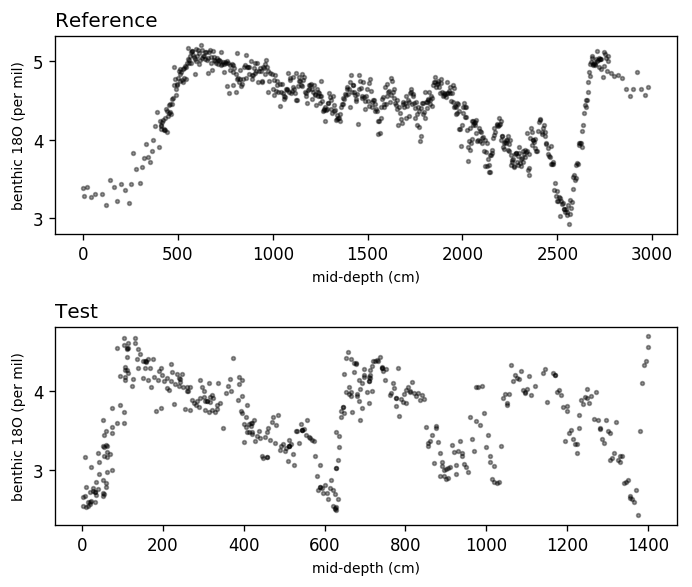

In [3]:
# make a plot
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rd.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=rax, s=5, c='k', alpha=0.4)
rax.set_title('Reference', loc='left')

tax = td.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=tax, s=5, c='k', alpha=0.4)
tax.set_title('Test', loc='left')

# rax.axvspan(0, 2950, color='r', alpha=0.2, zorder=-1)
# tax.axvspan(0, 720, color='r', alpha=0.2, zorder=-1)

fig.tight_layout()

**Sampling interval**
 - Reference = 1cm
 - Test = 2cm

## Smooth Data

Necessary, so we don't interpret noise.

Here we're using a 'smoothing spline', which splits the data into chunks, fits a polynomial to each chunk independently, and then re-combines the polynomials to create a smoothed profile for the whole line.

Because it's a polynomial, the derivative (slope) can be calculated analytically, making it very easy to work out gradients and roots for the smoothed data. This is why we've used a polynomial spline.

There are lots of other ways to smooth data, for example a fourier filter or a moving average. We can talk more about these in future sessions, if people are interested.

In [4]:
# import a UnivariateSpline smoother
from scipy.interpolate import UnivariateSpline as uspline

In [5]:
# grab subsets of data within same approx range
td = td.loc[(td.loc[:, 'mid-depth (cm)'] > 0) & (td.loc[:, 'mid-depth (cm)'] < 720)]
rd = rd.loc[(rd.loc[:, 'mid-depth (cm)'] > 110) & (rd.loc[:, 'mid-depth (cm)'] < 2950)]

In [6]:
# average duplicate x axis
td = td.groupby('mid-depth (cm)').aggregate(np.mean)
td.reset_index(drop=False, inplace=True)

# this is necessary because the function we're using to fit the 
# polynomials falls over if there are duplicate x values. There might
# be a better polynomial algorithm that doesn't, but a quick Google
# didn't turn one up, so I'm bodging it!

In [7]:
# extract x and y data from our DataFrames, for simplicity lower down.
tx = td.loc[:, 'mid-depth (cm)'].values
ty = td.loc[:, 'benthic 18O (per mil)'].values

rx = rd.loc[:, 'mid-depth (cm)']
ry = rd.loc[:, 'benthic 18O (per mil)']

# polynomial parameters
k = 5  # order of spline polynomial
ts = 3  # smoothing factor for test data
rs = 10  # smoothing factor for reference data
# Note: higher = more smoothed / less detail preserved


# Smoothing factors chosen arbitrarily so that they
# pick out features of interest in the data. Change these,
# and see what it does to the smooth.

# test data
# calculate smoothing spline
tsp = uspline(tx, ty, k=k, s=ts)
# generate smoothed data
tx_n = np.linspace(0,720,500)  # new x-scale
ty_sm = tsp(tx_n)

# reference data
# calculate smoothing spline
rsp = uspline(rx, ry, k=k, s=rs)
# generate smoothed data
rx_n = np.linspace(150,2950, 500)
ry_sm = rsp(rx_n)

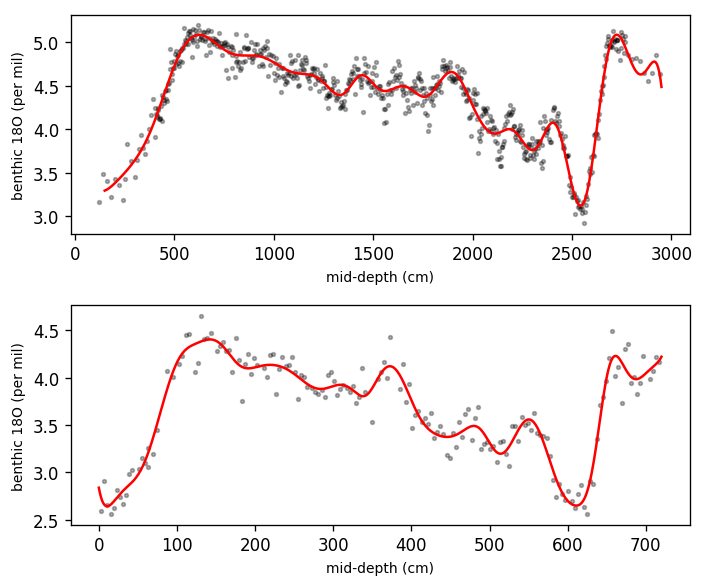

In [8]:
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rd.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=rax, s=5, c='k', alpha=0.3)
td.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=tax, s=5, c='k', alpha=0.3)

fig.tight_layout()

# plot the new smoothed profiles
tax.plot(tx_n, ty_sm, c='r')
rax.plot(rx_n, ry_sm, c='r')

### First Derivative (Gradient of smoothed signal)

In [9]:
tsp_d1 = tsp.derivative()
rsp_d1 = rsp.derivative()

# Note: each of these produces a new *function*, which you feed 
# x-values to calculate the 1st derivative y values.

In [10]:
# use the new functions to calculate the first derivative on a continuous x-scale
ty_d1 = tsp_d1(tx_n)
ry_d1 = rsp_d1(rx_n)

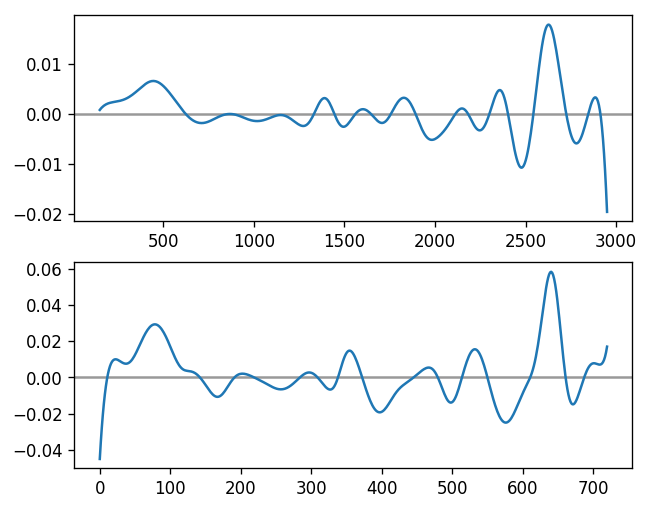

In [11]:
# plot first derivative

fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rax.plot(rx_n, ry_d1)
tax.plot(tx_n, ty_d1)

for ax in axs:
    ax.axhline(0, c='k', alpha=0.4, zorder=-1)

### Second Derivative (Gradient of First Derivative)

In [12]:
tsp_d2 = tsp_d1.derivative()
rsp_d2 = rsp_d1.derivative()

In [13]:
ty_d2 = tsp_d2(tx_n)
ry_d2 = rsp_d2(rx_n)

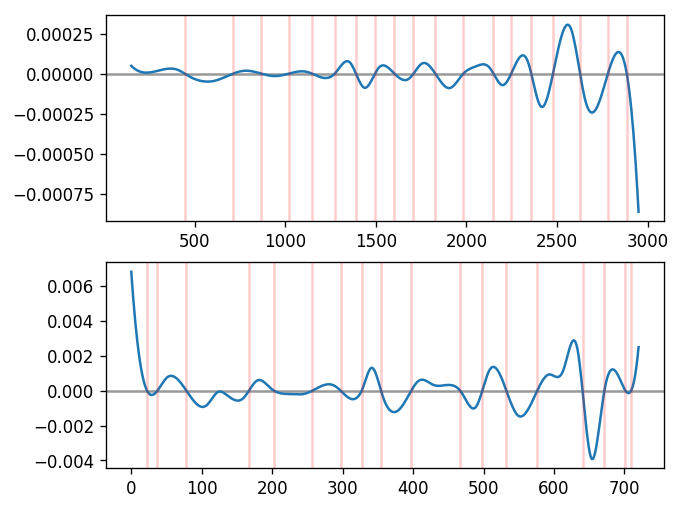

In [14]:
# draw second derivative, show roots
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rax.plot(rx_n, ry_d2)
tax.plot(tx_n, ty_d2)

for ax in axs:
    ax.axhline(0, c='k', alpha=0.4, zorder=-1)

# draw roots
for tr in tsp_d2.roots():
    tax.axvline(tr, c='r', alpha=0.2)
for rr in rsp_d2.roots():
    rax.axvline(rr, c='r', alpha=0.2)

This shows a red line wherever the 2nd derivative equals zero - i.e. peaks and troughs in the 1st derivative. To prove this to ourselves, let's plot these same lines on the 1st derivative curve:

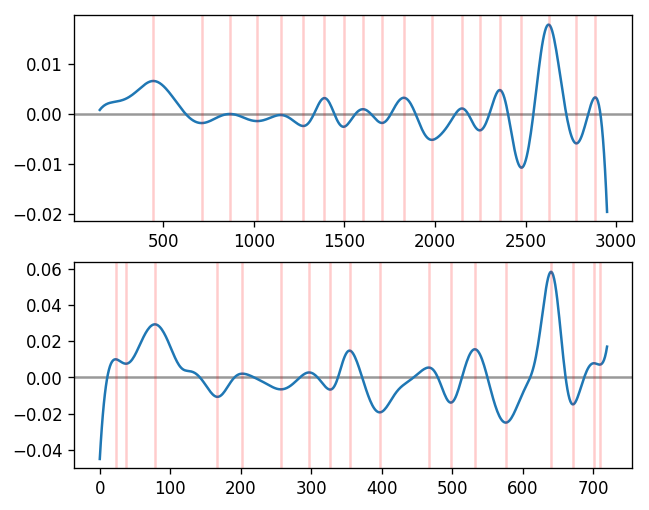

In [15]:
# draw roots on 1st derivative
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rax.plot(rx_n, ry_d1)
tax.plot(tx_n, ty_d1)

for ax in axs:
    ax.axhline(0, c='k', alpha=0.4, zorder=-1)

# draw 2nd diff roots
for tr in tsp_d2.roots():
    tax.axvline(tr, c='r', alpha=0.2)
for rr in rsp_d2.roots():
    rax.axvline(rr, c='r', alpha=0.2)

Yes! There's a red line wherever there's a peak or a trough! What does this look like on the raw data? Should be at the points of maximum gradient (i.e. inflection points):

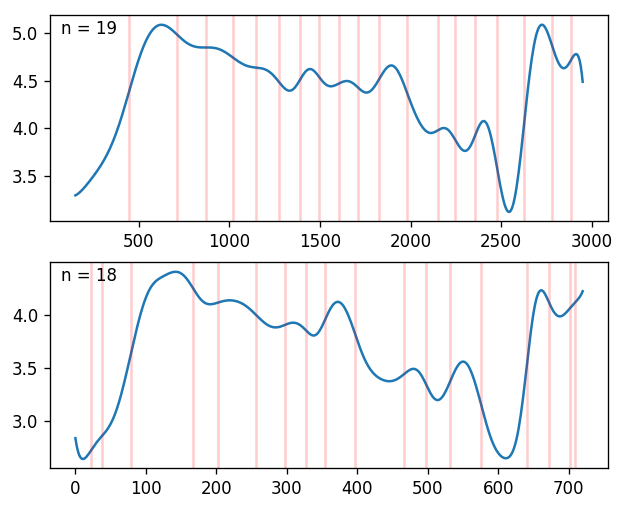

In [16]:
# Draw roots on smoothed data
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rax.plot(rx_n, ry_sm)
tax.plot(tx_n, ty_sm)

# draw 2nd diff roots
for tr in tsp_d2.roots():
    tax.axvline(tr, c='r', alpha=0.2)
for rr in rsp_d2.roots():
    rax.axvline(rr, c='r', alpha=0.2)

tax.text(.02, .98, 'n = {:.0f}'.format(len(tsp_d2.roots())), transform=tax.transAxes, va='top', ha='left')
rax.text(.02, .98, 'n = {:.0f}'.format(len(rsp_d2.roots())), transform=rax.transAxes, va='top', ha='left')

Looks reasonable!

## Problem: which roots match?
Note that there are 19 roots for the reference signal, and 18 for the test signal... Which ones match?

#### Thoughts:
- We could cross-correlate them (plot one against the other), and remove a single reference tie point until we get the best correlation between the two. This might work, but are all the tie-points equally valid?
- We can be most confident about a tie-point that is present at the steeper gradients. i.e. the tie points ~2600 in the reference signal is more robust than the one at ~1000. Perhaps focus on only the tie points at the steepest parts of the curve?

Let's try this:
1) Get all roots of 2nd derivative
2) Find the 1st derivative (slope) at all the second derivative roots.
3) Sort the first derivatives by magnitude, and define a cutoff that identifies the top N gradients (i.e. there should only be N roots where the first derivative is greater than the cutoff)
4) Get all the roots whose 1st derivative is greater than the cutoff!

In [17]:
# find the n steepest gradients in the original signal
n = 6

# 1) get all 2nd derivative roots
rroots = rsp_d2.roots()
troots = tsp_d2.roots()

# 2) get 1st derivative value at all 2nd derivative roots
rd1_vals = rsp_d1(rroots)
td1_vals = tsp_d1(troots)

# 3) sort roots by absolute value of 1st derivative, and determine cutoff for top n
rcutoff = sorted(abs(rd1_vals), reverse=True)[n]
tcutoff = sorted(abs(td1_vals), reverse=True)[n]

# 4) get roots associated with top n 1st derivative values
rtop5_roots = sorted(rroots[abs(rd1_vals) > rcutoff])
ttop5_roots = sorted(troots[abs(td1_vals) > tcutoff])

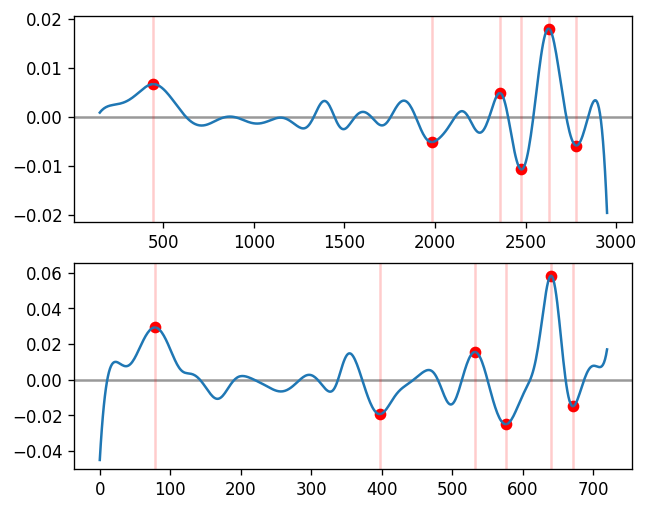

In [18]:
# draw roots on 1st derivative
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rax.plot(rx_n, ry_d1)
tax.plot(tx_n, ty_d1)

for ax in axs:
    ax.axhline(0, c='k', alpha=0.4, zorder=-1)

# draw 2nd diff roots
for tr in ttop5_roots:
    tax.axvline(tr, c='r', alpha=0.2)
    tax.scatter(tr, tsp_d1(tr), c='r')
for rr in rtop5_roots:
    rax.axvline(rr, c='r', alpha=0.2)
    rax.scatter(rr, rsp_d1(rr), c='r')

Looks convincing!

## What is the uncertainty on these tie-points?

i.e. how sensitive are these tie-points to the uncewrtainties in the raw data?

In [19]:
def d1_peaks(x, y, s, n=None, match=None):
    sm = uspline(x, y, s=s, k=5)
    d1 = sm.derivative()
    d2 = d1.derivative()

    roots = d2.roots()
    
    # if n is specified, return the top n 2nd deriv roots
    # sorted by absolute 1st derivative values.
    if n is not None:
        d1_vals = d1(roots)
        cutoff = sorted(abs(d1_vals), reverse=True)[n]
        return sorted(roots[abs(d1_vals) > cutoff])

    # match is specified, return the roots closest to the
    # points specified in match.
    elif match is not None:
        if isinstance(match, (float, int)):
            match = [match]
        
        out = np.zeros(len(match))
        for i, m in enumerate(match):
            ad = abs(roots - m)
            out[i] = roots[ad == min(ad)]
        return out

    # if neither is specified, return all roots, sorted by value
    else:
        return sorted(roots)

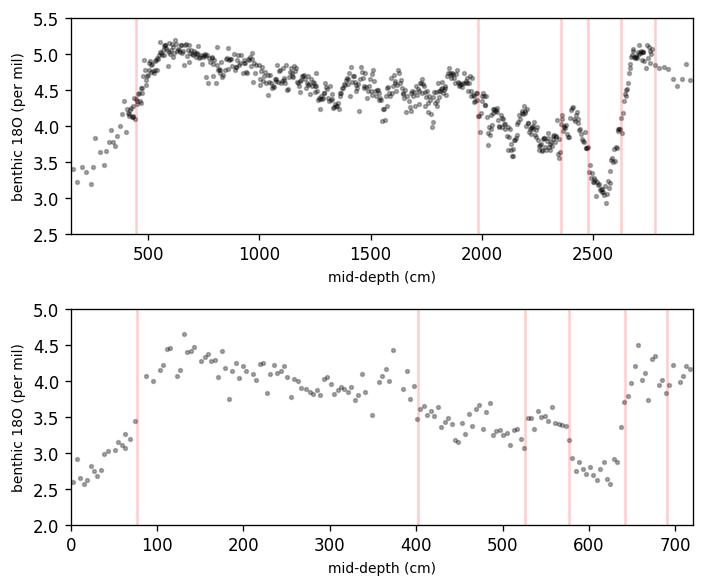

In [20]:
# test the function
fig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rd.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=rax, s=5, c='k', alpha=0.3)
rax.set_xlim(150,2950)
rax.set_ylim(2.5,5.5)

td.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=tax, s=5, c='k', alpha=0.3)
tax.set_xlim(0,720)
tax.set_ylim(2,5)

# calclate tie points using function
ties = 6
rr = d1_peaks(rx, ry, 10, ties)
tr = d1_peaks(tx, ty, 4, ties)

# draw tie points
for r in rr:
    rax.axvline(r, c='r', alpha=0.2)
for r in tr:
    tax.axvline(r, c='r', alpha=0.2)

fig.tight_layout()

## Uncertainties: Monte Carlo it?

Where by 'Monte Carlo' we mean repeat everything above [MANY] times, varying all the data points within their analytical uncertainties, to see how the tie points change.

In [21]:
from tqdm import tqdm  # for progress bars

In [22]:
# data and errors
tx = td.loc[:, 'mid-depth (cm)'].values
ty = td.loc[:, 'benthic 18O (per mil)'].values
tx_err = 1  # ± uncertainty in sampling depth (2 cm intervals)
ty_err = 0.08  # uncertainty in d18O measurement

rx = rd.loc[:, 'mid-depth (cm)']
ry = rd.loc[:, 'benthic 18O (per mil)']
rx_err = 0.5  # ± uncertainty in sampling depth (1 cm intervals)
ry_err = 0.1  # uncertainty in d18O measurement

In [23]:
niter = 5000
nties = 6
# nties = len(rr)

# create empty arrays for the results
t_tpoints = np.zeros((niter, nties))
r_tpoints = np.zeros((niter, nties))

# Two approaches:

## 1) 'How stable are the steepest gradient points in my data,
##    given the uncertainties in my data?'
# for i in tqdm(range(niter)):
#     r_tpoints[i,:] = d1_peaks(rx + np.random.uniform(-rx_err, rx_err, rx.size),
#                               ry + np.random.normal(0, ry_err, ry.size), 
#                               s=10, n=nties)
#     t_tpoints[i,:] = d1_peaks(tx + np.random.uniform(-tx_err, tx_err, tx.size), 
#                               ty + np.random.normal(0, ty_err, ty.size),
#                               s=4, n=nties)


# 2) 'How sensitive are the six steepest gradients identified in my 
#    actual data to the uncertainties in my data?'
for i in tqdm(range(niter)):
    r_tpoints[i,:] = d1_peaks(rx + np.random.uniform(-rx_err, rx_err, rx.size),
                              ry + np.random.normal(0, ry_err, ry.size), 
                              s=10, match=rr)
    t_tpoints[i,:] = d1_peaks(tx + np.random.uniform(-tx_err, tx_err, tx.size), 
                              ty + np.random.normal(0, ty_err, ty.size),
                              s=4, match=tr)

100%|██████████| 5000/5000 [00:25<00:00, 196.48it/s]


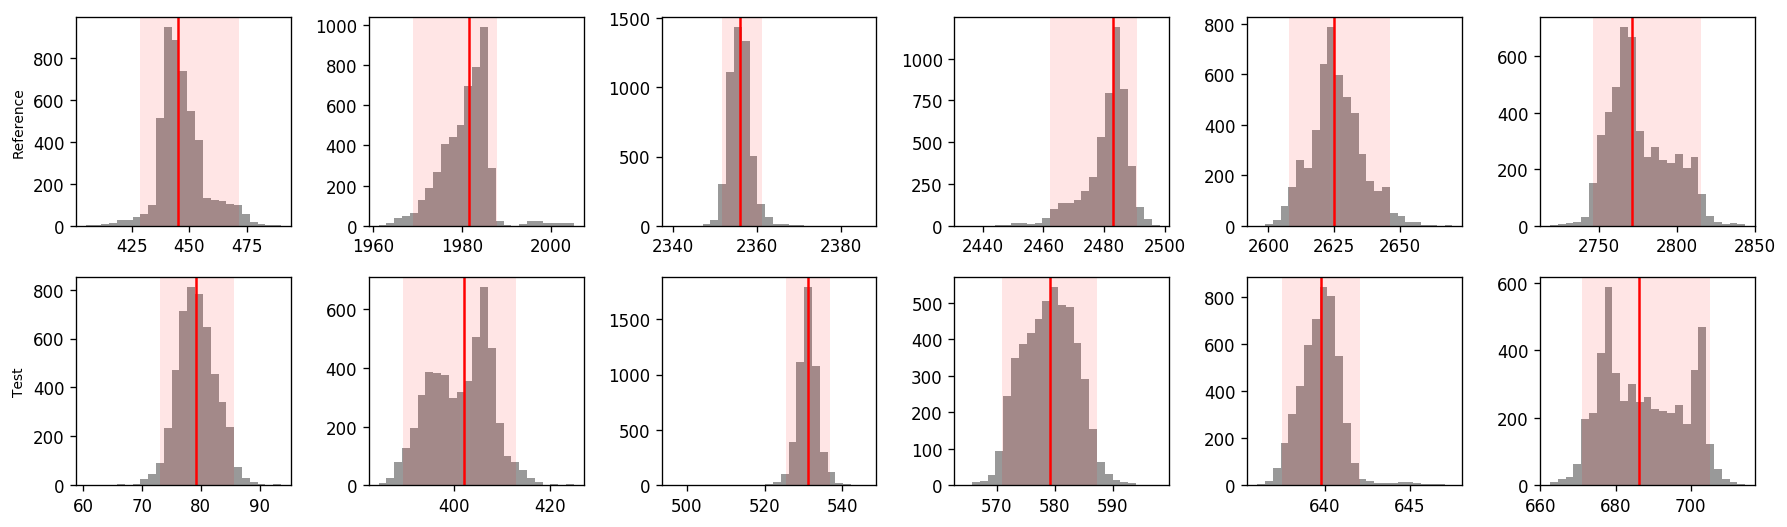

In [24]:
# look at the calculated tie points
fig, axs = plt.subplots(2, nties, figsize=(nties*2.5,4.5))

for i, ax in enumerate(axs[0]):
    ax.hist(r_tpoints[:, i], 25, color=(0,0,0,0.4), lw=0)
    ax.axvline(np.median(r_tpoints[:, i]), c='r')
    ax.axvspan(*np.percentile(r_tpoints[:, i], (2.5, 97.5)), 
               color='r', alpha=0.1, lw=0)
    
    if ax.is_first_col():
        ax.set_ylabel('Reference')

for i, ax in enumerate(axs[1]):
    ax.hist(t_tpoints[:, i], 25, color=(0,0,0,0.4), lw=0)
    ax.axvline(np.median(t_tpoints[:, i]), c='r')
    ax.axvspan(*np.percentile(t_tpoints[:, i], (2.5, 97.5)), 
               color='r', alpha=0.1, lw=0)

    if ax.is_first_col():
        ax.set_ylabel('Test')

fig.tight_layout()

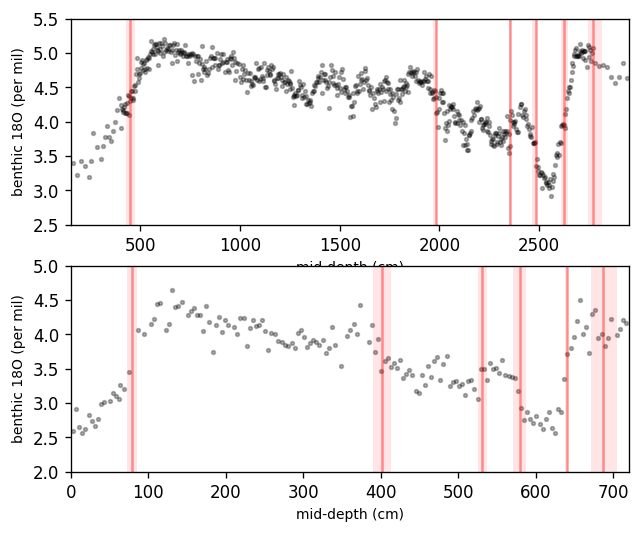

In [25]:
# What do these look like on the actual signals?
tfig, axs = plt.subplots(2, 1, figsize=[6,5])
rax, tax = axs

rd.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=rax, s=5, c='k', alpha=0.3)
rax.set_xlim(150,2950)
rax.set_ylim(2.5,5.5)

td.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', ax=tax, s=5, c='k', alpha=0.3)
tax.set_xlim(0,720)
tax.set_ylim(2,5)
fig.tight_layout()

for i in range(t_tpoints.shape[-1]):
    tax.axvline(np.median(t_tpoints[:, i]), c='r', alpha=0.4)
    tax.axvspan(*np.percentile(t_tpoints[:, i], (2.5, 97.5)), 
                color='r', alpha=0.1, lw=0)

for i in range(r_tpoints.shape[-1]):
    rax.axvline(np.median(r_tpoints[:, i]), c='r', alpha=0.4)
    rax.axvspan(*np.percentile(r_tpoints[:, i], (2.5, 97.5)), 
                color='r', alpha=0.1, lw=0)

## Applying the Correction

In [26]:
tmed = np.apply_along_axis(np.median, 0, t_tpoints)
tlo, thi = np.apply_along_axis(np.percentile, 0, t_tpoints, (2.5, 97.5))

rmed = np.apply_along_axis(np.median, 0, r_tpoints)
rlo, rhi = np.apply_along_axis(np.percentile, 0, r_tpoints, (2.5, 97.5))

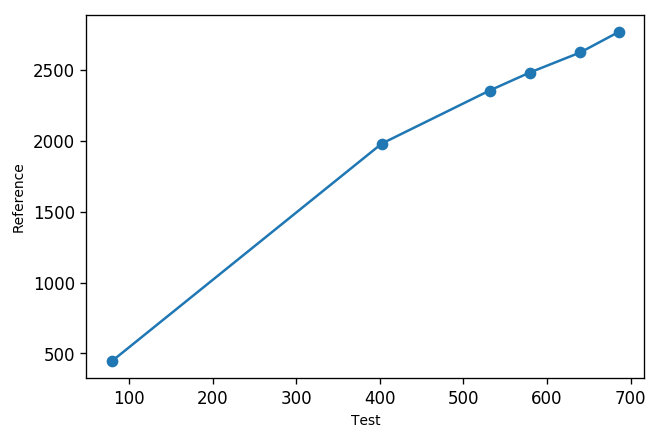

In [27]:
plt.scatter(tmed, rmed)
plt.plot(tmed, rmed)

plt.xlabel('Test')
plt.ylabel('Reference')

### Linear Interpolation

In [28]:
from scipy.interpolate import interp1d

In [29]:
# interpolator
newscale = interp1d(tmed, rmed, bounds_error=False)
# calculate new scale
td['new_depth'] = newscale(td['mid-depth (cm)'])

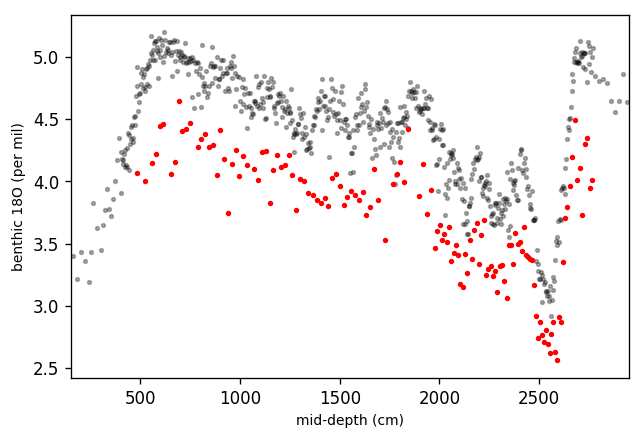

In [30]:
ax = rd.plot('mid-depth (cm)', 'benthic 18O (per mil)', kind='scatter', s=5, c='k', alpha=0.3)
ax.set_xlim(150,2950)
# ax.set_ylim(2.5,5.5)

ax.scatter(td.new_depth, td['benthic 18O (per mil)'], c='r', s=5)

## Not terrible!

Looks *fairly* convincing... but this neglects the errors on the tie-points that we spend so long working out... How should we include these?

### How to propagate tie-point error?

#### Simple option:
Create an error envelope based on the errors at each tie-point. Is this realistic?

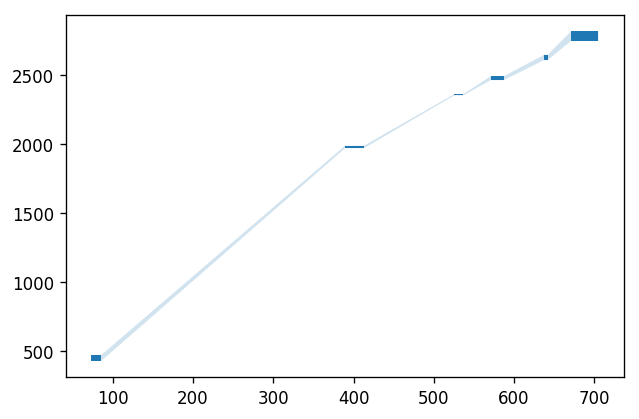

In [31]:
fig, ax = plt.subplots(1,1)

ax.scatter(tmed, rmed, s=1, c=(0,0,0,0))

errs = []
for xlo, xhi, ylo, yhi in zip(tlo, thi, rlo, rhi):
    errs.append(mpl.patches.Polygon([[xlo, ylo],
                                     [xhi, ylo],
                                     [xhi, yhi],
                                     [xlo, yhi]]))

err_collection = mpl.collections.PatchCollection(errs)
    
ax.add_collection(err_collection)

xn = np.empty(tlo.size * 2)
xn[0::2] = tlo
xn[1::2] = thi

ynhi = np.empty(rhi.size * 2)
ynlo = np.empty(rlo.size * 2)

ynhi[0::2] = rhi
ynhi[1::2] = rhi

ynlo[0::2] = rlo
ynlo[1::2] = rlo

ax.fill_between(xn, ynhi, ynlo, alpha=0.2)

#### More complex (realistic?) option:
There are multiple possible 'paths' between each tie point. The end members are in the light blue boxes below. In this case (sediments) it's *extremely* unlikely to 'dump' all your sediment at once, so these end-members are extremeley unlikely. However, it's also unlikely to be linear (as above). You could do this probabistically, using maximum and minimum likely sedimentation rates in the environment to build up an interpolation envelope between the tie points... but that's for another time.

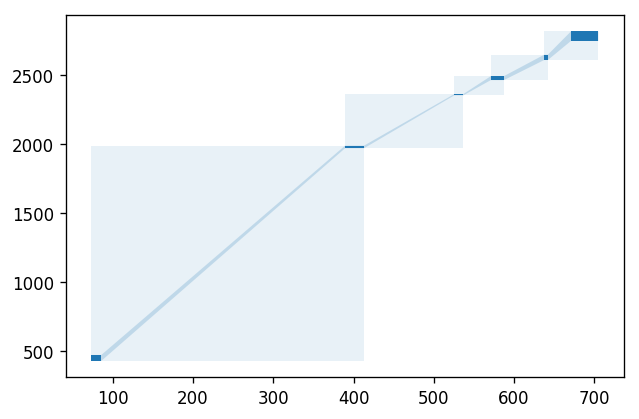

In [32]:
fig, ax = plt.subplots(1,1)

ax.scatter(tmed, rmed, s=1, c=(0,0,0,0))

errs = []
for xlo, xhi, ylo, yhi in zip(tlo, thi, rlo, rhi):
    errs.append(mpl.patches.Polygon([[xlo, ylo],
                                     [xhi, ylo],
                                     [xhi, yhi],
                                     [xlo, yhi]]))

err_collection = mpl.collections.PatchCollection(errs)
    
ax.add_collection(err_collection)

xn = np.empty(tlo.size * 2)
xn[0::2] = tlo
xn[1::2] = thi

ynhi = np.empty(rhi.size * 2)
ynlo = np.empty(rlo.size * 2)

ynhi[0::2] = rhi
ynhi[1::2] = rhi

ynlo[0::2] = rlo
ynlo[1::2] = rlo

ax.fill_between(xn, ynhi, ynlo, alpha=0.2)


# uncertainty envelopes
unc = []
for i in range(tmed.size - 1):
    xlo = tlo[i]
    xhi = thi[i + 1]
    ylo = rlo[i]
    yhi = rhi[i + 1]
    
    unc.append(mpl.patches.Polygon([[xlo, ylo],
                                    [xhi, ylo],
                                    [xhi, yhi],
                                    [xlo, yhi]]))
unc_collection = mpl.collections.PatchCollection(unc, alpha=0.1, zorder=-2)

ax.add_collection(unc_collection)

### Complex... can revisit this if interested.